In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-859.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-158.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10121.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1811.png
/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-97.png
/kaggle/input/covid19-radiography-database/COVID-19_Radi

In [2]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=87b17b586d2ae167da873f8d854b8d2023a85c626b406b9145b6c1261700a0e1
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
import cv2
import os, glob

import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception 
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout, BatchNormalization, Conv2D

In [4]:
LR = 0.001
EPOCHS = 50
BATCH_SIZE = 32
# 3616 COVID-19 positive cases along with 10,192 Normal, 
#6012 Lung Opacity (Non-COVID lung infection),
#and 1345 Viral Pneumonia images.
Cov_Len = 3616
Nor_Len = 10192
Lung_Len = 6012
Viral_Len = 1345
Def_Len = 218
INP_SIZE = (224,224,3)

In [5]:
def create_data(dir_name):
    temp_data = []
    img_list = glob.glob(dir_name + '/*')
    for img in img_list[:Def_Len]:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        temp_data.append(image)
    return temp_data

data = []
labels = []


COVID_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
Normal_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
Viral_Pneumonia_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia'
Lung_Opacity_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity'

data.extend(create_data(COVID_dir))
data.extend(create_data(Normal_dir))
data.extend(create_data(Viral_Pneumonia_dir))
data.extend(create_data(Lung_Opacity_dir))

labels.extend(['0']*Def_Len)
labels.extend(['1']*Def_Len)
labels.extend(['2']*Def_Len)
labels.extend(['3']*Def_Len)

data = np.array(data)/255.0
labels = np.array(labels)

print(data.shape)
print(labels.shape)

(872, 224, 224, 3)
(872,)


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
print(labels.shape)
print(labels)

(x_train, x_test, y_train, y_test) = train_test_split(
    data,
    labels,
    test_size=0.30,
    stratify=labels,
    random_state=42)

trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(872, 4)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]
(610, 224, 224, 3)
(610, 4)
(262, 224, 224, 3)
(262, 4)


In [7]:
def generate_custom_model():
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=INP_SIZE))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Dropout(0.35))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(4, activation='softmax'))
    
    return model

def generate_pretrained_model(model_name):
    if model_name == 'VGG16':
        model = VGG16(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'ResNet101':
        model = ResNet101(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    elif model_name == 'Xception':
        model = Xception(
            include_top = False,
            weights = 'imagenet',
            input_tensor = Input(shape=INP_SIZE)
        )
    else:
        model = None
        print('Invalid Choice!')
    
    return model

In [8]:
def fit_model(model, model_name):
    optim = Adam(lr = LR, decay = LR/EPOCHS)
    
    if model_name == 'Custom':
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    else :
        for layer in model.layers:
            layer.trainable = False
        # top layer for shaping output    
        headModel = model.output
        headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(64, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(4, activation="softmax")(headModel)
        model = Model(inputs=model.input, outputs=headModel)
        model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])
         
        history = model.fit_generator(
            trainAug.flow(x_train, y_train, batch_size = BATCH_SIZE),
            steps_per_epoch = len(x_train) // BATCH_SIZE,
            validation_data = (x_test, y_test),
            validation_steps = len(x_test) // BATCH_SIZE,
            epochs = EPOCHS
        )
    
    return history, model

In [9]:
def display_history(history_):
    fig, ax = plt.subplots(1,2, figsize=(12, 3))
    ax[0].plot(history_.history['loss'], color='b', label="training_loss")
    ax[0].plot(history_.history['val_loss'], color='r', label="validation_loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history_.history['accuracy'], color='b', label="training_accuracy")
    ax[1].plot(history_.history['val_accuracy'], color='r',label="validation_accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

def plot_metrices(model_):
    
    plt.figure()
    ax = plt.subplot()
    ax.set_title('Confusion Matrix')
    
     
    pred = model_.predict(x_test, batch_size = BATCH_SIZE)
    pred = np.argmax(pred, axis = 1)
    cm = confusion_matrix(y_test.argmax(axis = 1), pred)
    classes=['normal', 'covid19', 'Lung_Opacity', 'Viral_Pneumonia']
    sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes, cmap = 'Reds')
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show
    
    print(classification_report(y_test.argmax(axis = 1), pred))
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print("ACC: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

In [10]:
custom_mod = generate_custom_model()
vgg_mod = generate_pretrained_model('VGG16')
resnet_mod = generate_pretrained_model('ResNet101')
xception_mod = generate_pretrained_model('Xception')

83689472/83683744 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
19/19 [==============================] - 10s 343ms/step - loss: 8.3014 - accuracy: 0.3263 - val_loss: 1.3847 - val_accuracy: 0.3397
Epoch 2/50
19/19 [==============================] - 6s 294ms/step - loss: 1.2748 - accuracy: 0.4052 - val_loss: 1.2174 - val_accuracy: 0.4962
Epoch 3/50
19/19 [==============================] - 6s 340ms/step - loss: 1.0937 - accuracy: 0.5158 - val_loss: 1.1427 - val_accuracy: 0.5573
Epoch 4/50
19/19 [==============================] - 6s 298ms/step - loss: 0.9662 - accuracy: 0.6075 - val_loss: 1.0094 - val_accuracy: 0.5763
Epoch 5/50
19/19 [==============================] - 6s 315ms/step - loss: 0.8926 - accuracy: 0.6134 - val_loss: 0.9824 - val_accuracy: 0.5687
Epoch 6/50
19/19 [==============================] - 6s 299ms/step - loss: 0.8511 - accuracy: 0.6042 - val_loss: 0.9868 - val_accuracy: 0.6336
Epoch 7/50
19/19 [==============================] - 6s 303ms/step - loss: 0.8672 - accuracy: 0.6337 - val_loss: 0.8966 - val_accuracy: 0.6603
Epoch

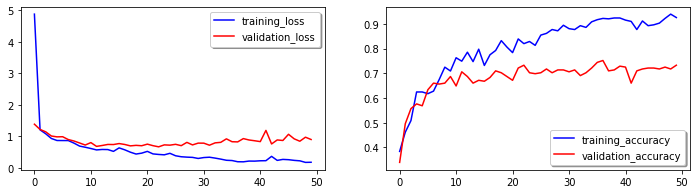

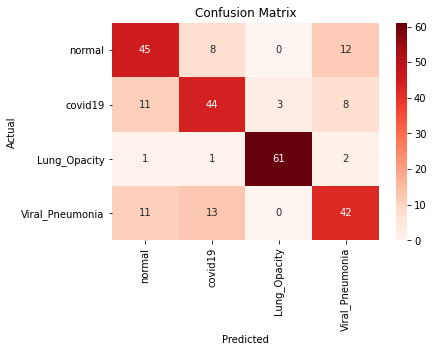

In [11]:
(cus_his, custom_mod) = fit_model(custom_mod, 'Custom')
display_history(cus_his)
plot_metrices(custom_mod)
custom_mod.save('custom.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
19/19 [==============================] - 10s 446ms/step - loss: 1.4906 - accuracy: 0.2708 - val_loss: 1.3205 - val_accuracy: 0.3626
Epoch 2/50
19/19 [==============================] - 7s 363ms/step - loss: 1.3619 - accuracy: 0.3530 - val_loss: 1.2569 - val_accuracy: 0.5267
Epoch 3/50
19/19 [==============================] - 6s 332ms/step - loss: 1.2590 - accuracy: 0.4377 - val_loss: 1.2201 - val_accuracy: 0.5611
Epoch 4/50
19/19 [==============================] - 7s 357ms/step - loss: 1.2198 - accuracy: 0.4981 - val_loss: 1.1710 - val_accuracy: 0.5725
Epoch 5/50
19/19 [==============================] - 6s 340ms/step - loss: 1.2029 - accuracy: 0.4559 - val_loss: 1.1381 - val_accuracy: 0.5687
Epoch 6/50
19/19 [==============================] - 6s 339ms/step - loss: 1.1716 - accuracy: 0.4889 - val_loss: 1.1217 - val_accuracy: 0.5611
Epoch 7/50
19/19 [==============================] - 7s 347ms/step - loss: 1.1430 - accuracy: 0.4982 - val_loss: 1.0925 - val_accuracy: 0.5725
Epoch

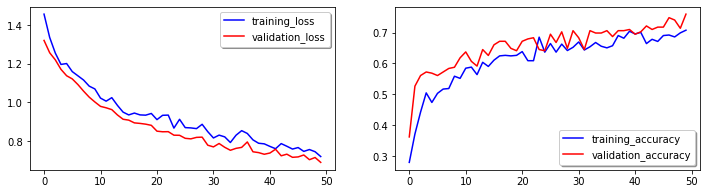

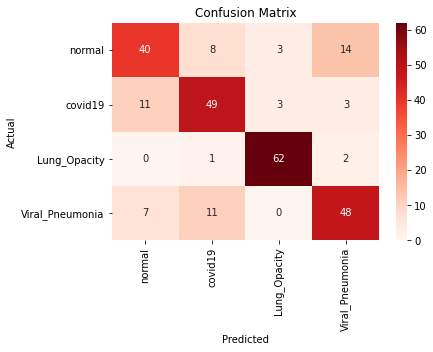

In [12]:
(vgg_his, vgg_mod)= fit_model(vgg_mod, 'VGG16')
display_history(vgg_his)
plot_metrices(vgg_mod)
vgg_mod.save('vgg.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
19/19 [==============================] - 15s 488ms/step - loss: 1.5230 - accuracy: 0.2303 - val_loss: 1.3837 - val_accuracy: 0.2481
Epoch 2/50
19/19 [==============================] - 7s 353ms/step - loss: 1.3875 - accuracy: 0.2907 - val_loss: 1.3826 - val_accuracy: 0.2481
Epoch 3/50
19/19 [==============================] - 7s 366ms/step - loss: 1.3839 - accuracy: 0.2707 - val_loss: 1.3825 - val_accuracy: 0.2634
Epoch 4/50
19/19 [==============================] - 7s 350ms/step - loss: 1.3831 - accuracy: 0.2793 - val_loss: 1.3792 - val_accuracy: 0.3168
Epoch 5/50
19/19 [==============================] - 7s 380ms/step - loss: 1.3851 - accuracy: 0.2937 - val_loss: 1.3769 - val_accuracy: 0.3740
Epoch 6/50
19/19 [==============================] - 7s 367ms/step - loss: 1.3866 - accuracy: 0.2686 - val_loss: 1.3759 - val_accuracy: 0.4237
Epoch 7/50
19/19 [==============================] - 7s 352ms/step - loss: 1.3721 - accuracy: 0.2945 - val_loss: 1.3769 - val_accuracy: 0.3702
Epoch

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.38      0.72      0.50        65
           1       0.31      0.24      0.27        66
           2       0.63      0.83      0.72        65
           3       0.00      0.00      0.00        66

    accuracy                           0.45       262
   macro avg       0.33      0.45      0.37       262
weighted avg       0.33      0.45      0.37       262

ACC: 0.2405
Sensitivity: 0.7581
Specificity: 0.3636


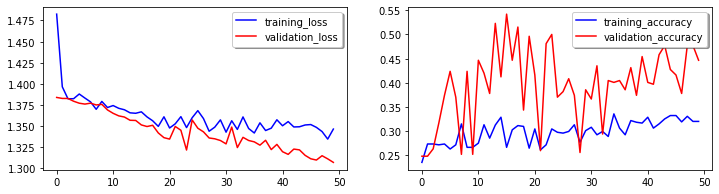

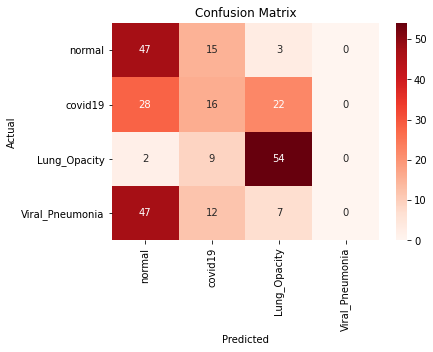

In [13]:
res_his, resnet_mod = fit_model(resnet_mod, 'ResNet101')
display_history(res_his)
plot_metrices(resnet_mod)
resnet_mod.save('resnet.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
19/19 [==============================] - 11s 441ms/step - loss: 1.2186 - accuracy: 0.4124 - val_loss: 0.8148 - val_accuracy: 0.6336
Epoch 2/50
19/19 [==============================] - 7s 350ms/step - loss: 0.8752 - accuracy: 0.6523 - val_loss: 0.7495 - val_accuracy: 0.6679
Epoch 3/50
19/19 [==============================] - 7s 357ms/step - loss: 0.7462 - accuracy: 0.6870 - val_loss: 0.6981 - val_accuracy: 0.6985
Epoch 4/50
19/19 [==============================] - 7s 346ms/step - loss: 0.7204 - accuracy: 0.6954 - val_loss: 0.7045 - val_accuracy: 0.7023
Epoch 5/50
19/19 [==============================] - 6s 337ms/step - loss: 0.6851 - accuracy: 0.7398 - val_loss: 0.6899 - val_accuracy: 0.7137
Epoch 6/50
19/19 [==============================] - 7s 337ms/step - loss: 0.6991 - accuracy: 0.7368 - val_loss: 0.6698 - val_accuracy: 0.7176
Epoch 7/50
19/19 [==============================] - 7s 377ms/step - loss: 0.5609 - accuracy: 0.7943 - val_loss: 0.6542 - val_accuracy: 0.7328
Epoch

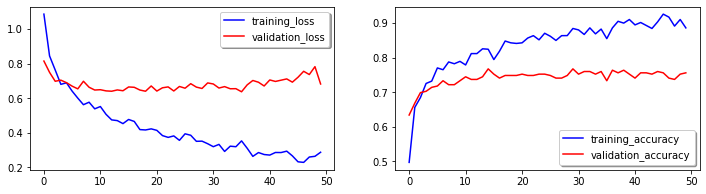

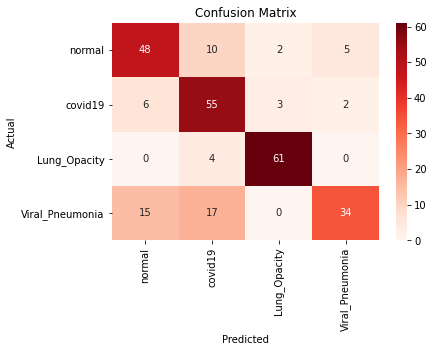

In [14]:
xcep_his, xception_mod = fit_model(xception_mod, 'Xception')
display_history(xcep_his)
plot_metrices(xception_mod)
xception_mod.save('xception.h5')